#### Practical strategies for ships passing limited water depth to achieve multiple goals
- Strategies include vessel sailing velocities, payload adjustment(actual draught), parcial engine load
- multiple goals covers the indicators of fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway). 

##### Steps
- present a waterway section with limited water depth (150 km with 2.5 m water depth) on the graph
- provide a list of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
- use get_v funtion to get maximum feasible velocity considering both installed enegine power and ship squat while moving at a speed
- for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
- use 'Parallel coordinate plot' to visualise strategies
- Automatically select optimal strategies to achieve the goal of less transport time, less emissions, less fuel use, safety guarantees.

In [1]:

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling

import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# Used for mathematical functions
import math             

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

# Used for making the graph
import networkx as nx

# OpenTNSim
import opentnsim


#### Present the waterway section with limited water depth on the graph network

In [2]:
# We're in engineering cordinates (m)
coords = [
    [0,0],
    [8.983,0], 
    [17.966,0],
    [17.966,13.566],
    [17.966,22.609],
    [27.527,9.560],
    [33.903,15.931],
    [31.441,0],
    
    [40.424, 0],
    [19.560,-01.693],
    [33.904,-15.931]] 


# these are the indices of the points above
edge_indices = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [2, 5],
    [5, 6],
    [2, 7],
    [7, 8],
    [2, 9],
    [9, 10]   
]

depths = [12.5, 6, 6, 6, 4.5, 6, 2.5, 6, 2.5, 6] 

widths = [300, 150, 150, 150, 150, 150, 150, 150, 150, 150]

points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

In [3]:
# define Site class
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

In [4]:
FG = nx.DiGraph()

nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": str(index), "geometry": shapely.geometry.Point(points[index].x, points[index].y)}
    nodes.append(Node(**data_node))

for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)    
    
for index, edge in enumerate(edge_indices):
    edge_geometry = shapely.geometry.LineString([points[edge[0]], points[edge[1]]])
    edge_properties = dict(
        GeneralDepth = depths[index],
        width = widths[index],
        geometry = edge_geometry, 
        length = round(edge_geometry.length),
        e = tuple(edge)
    )
    FG.add_edge( str(edge[0]), str(edge[1]), weight = 1, Info = edge_properties)

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [5]:
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)

In [6]:
# collect node labels.
labels = {}
for node in FG.nodes:
    labels[node] = node

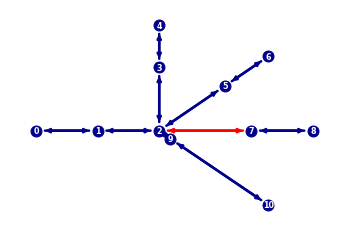

In [7]:
# draw edges, nodes and labels.
colors =['darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','r','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','r','darkblue','darkblue','darkblue','darkblue','darkblue']
nx.draw_networkx_edges(FG,  pos=positions, width=2.5, edge_color=colors, alpha=1, arrowsize=8)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=120)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=8, font_weight='bold', font_color="white")

plt.axis("off")
plt.savefig('graph_limited_water_depth.pdf', bbox_inches = 'tight', dpi=600, format='pdf') 
plt.show()

#### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [8]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [9]:
# Create a dict with all important settings
data_vessel = {
               "env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": None,  # m/s
               "type":  None, # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": 2.05,
               "safety_margin": 0.2, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
               "h_squat":True,
               "P_installed": 1750.0,   
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to none; otherwise set to 1.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2,# number of propellers
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }        
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

In [10]:
draught = opentnsim.strategy.Payload2T(vessel= vessel, Payload_strategy=1056, vessel_type= "Tanker")
draught 

1056 995.4777630730554 1.9098300562505255 Tanker
1056 2357.3339801398893 3.0901699437494736 Tanker
1056 171.52208911192673 1.1803398874989486 Tanker
1056 1044.6032263688046 1.952948260116881 Tanker
1056 1056.6440251292015 1.9635103328589776 Tanker
1056 1056.0063061524618 1.96295099432661 Tanker
1056 1055.9999275090765 1.9629453996310744 Tanker
1056 1055.9960939031682 1.9629420371825557 Tanker
T_Payload2T = 1.96


1.9629453996310744

#### Provide a group of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
here we choose M8 vessel as it has a large share of the sailing movements per year on waal (Rijkswaterstaat,2021, Safety aspects of new energy carriers in inland navigation), M8's draught ranges from 1.4 m to 3.5 m, considering a safety margin (minimum ukc) of 0.2 m at water depth 2.5 m, the final feasible draught ranges from 1.4 m to 2.3 m.

In [11]:
# provide max and min draught
max_draught = 2.30
min_operational_draught = 1.40
stepsize = -0.05

# create lists of strategy values
T_strategy = np.arange(max_draught, round(min_operational_draught + stepsize, 2), stepsize).round(2).tolist()
h_min = [2.5]
safety_margin = [0.2]
width = [150]


In [12]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product(T_strategy, h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T_strategy": item[0],"h_min":item[1], "safety_margin":item[2], "width":item[3]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(20)

,T_strategy,h_min,safety_margin,width
0,2.30,2.5,0.2,150
1,2.25,2.5,0.2,150
2,2.20,2.5,0.2,150
3,2.15,2.5,0.2,150
4,2.10,2.5,0.2,150
5,2.05,2.5,0.2,150
6,2.00,2.5,0.2,150
7,1.95,2.5,0.2,150
8,1.90,2.5,0.2,150
9,1.85,2.5,0.2,150


#### Caculate the maximum velocity the vessel can sail at for each T_strategy, considering maximum sinkage and installed engine power

In [13]:
Strategies = []

for i, row in tqdm.tqdm(work_df.iterrows(),disable=True):

    # get vessel 
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T_strategy']
    vessel.safety_margin = row['safety_margin']
    
    # estimate 'grounding speed' as a useful upperbound
    upperbound, selected, results_df = opentnsim.strategy.get_upperbound_for_power2v(vessel, width=row['width'], depth=row['h_min'], margin=0)
    
    # calculate the velocity that belongs to the T_strategy (while leaving the margin)
    v, depth, depth_squat, z_computed, margin = opentnsim.strategy.get_v(vessel, width=row['width'], depth=row['h_min'], margin=row['safety_margin'], bounds=(0, upperbound))
    
    # detaremine payload
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    
    Strategy ={}
    Strategy.update(row)
    Strategy['v_upper_bound (m/s)'] = upperbound # power allowed max v   
    Strategy['v_strategy (m/s)'] = v  # final max v considering squat and installed power
    Strategy['z_computed (m)'] = z_computed
    Strategy['depth squat (m)'] = depth_squat
    Strategy['T + margin (m)'] = row['T_strategy']+ row['safety_margin']
    
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted
    Strategies.append(Strategy)

eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28

In [14]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(Strategies_df)

,T_strategy,h_min,safety_margin,width,v_upper_bound (m/s),v_strategy (m/s),z_computed (m),depth squat (m),T + margin (m),Payload_strategy_tanker (ton)
0,2.30,2.50,0.20,150.00,2.84,0.00,0.00,2.50,2.50,1441.73
1,2.25,2.50,0.20,150.00,3.19,1.58,0.05,2.45,2.45,1384.33
2,2.20,2.50,0.20,150.00,3.48,2.23,0.10,2.40,2.40,1326.99
3,2.15,2.50,0.20,150.00,3.74,2.73,0.15,2.35,2.35,1269.71
4,2.10,2.50,0.20,150.00,3.98,3.17,0.20,2.30,2.30,1212.50
5,2.05,2.50,0.20,150.00,4.15,3.56,0.25,2.25,2.25,1155.35
6,2.00,2.50,0.20,150.00,4.36,3.92,0.30,2.20,2.20,1098.26
7,1.95,2.50,0.20,150.00,4.50,4.27,0.35,2.15,2.15,1041.24
8,1.90,2.50,0.20,150.00,4.57,4.57,0.40,2.10,2.10,984.28
9,1.85,2.50,0.20,150.00,4.68,4.68,0.41,2.09,2.05,927.39


#### Provide a group of feasible velocities for each T_strategy

In [15]:
# provide max and min draught
v_feasible_forT = []
for row in Strategies:
    max_velocity = row['v_strategy (m/s)']
    min_velocity = 1
    stepsize = -0.1
    # create lists of strategy values
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2).tolist()
    v_feasible_forT.append(v_feasible)
v_df = pd.DataFrame(v_feasible_forT).T
names=['T=2.30','T=2.25','T=2.20','T=2.15','T=2.10','T=2.05','T=2.00','T=1.95','T=1.90','T=1.85','T=1.80','T=1.75','T=1.70','T=1.65','T=1.60','T=1.55','T=1.50','T=1.45','T=1.40']
v_df.columns=names
v_df

,T=2.30,T=2.25,T=2.20,T=2.15,T=2.10,T=2.05,T=2.00,T=1.95,T=1.90,T=1.85,T=1.80,T=1.75,T=1.70,T=1.65,T=1.60,T=1.55,T=1.50,T=1.45,T=1.40
0,NaN,1.58,2.23,2.73,3.17,3.56,3.92,4.27,4.57,4.68,4.72,4.74,4.74,4.73,4.7,4.65,4.59,4.52,4.43
1,NaN,1.48,2.13,2.63,3.07,3.46,3.82,4.17,4.47,4.58,4.62,4.64,4.64,4.63,4.6,4.55,4.49,4.42,4.33
2,NaN,1.38,2.03,2.53,2.97,3.36,3.72,4.07,4.37,4.48,4.52,4.54,4.54,4.53,4.5,4.45,4.39,4.32,4.23
3,NaN,1.28,1.93,2.43,2.87,3.26,3.62,3.97,4.27,4.38,4.42,4.44,4.44,4.43,4.4,4.35,4.29,4.22,4.13
4,NaN,1.18,1.83,2.33,2.77,3.16,3.52,3.87,4.17,4.28,4.32,4.34,4.34,4.33,4.3,4.25,4.19,4.12,4.03
5,NaN,1.08,1.73,2.23,2.67,3.06,3.42,3.77,4.07,4.18,4.22,4.24,4.24,4.23,4.2,4.15,4.09,4.02,3.93
6,NaN,0.98,1.63,2.13,2.57,2.96,3.32,3.67,3.97,4.08,4.12,4.14,4.14,4.13,4.1,4.05,3.99,3.92,3.83
7,NaN,NaN,1.53,2.03,2.47,2.86,3.22,3.57,3.87,3.98,4.02,4.04,4.04,4.03,4.0,3.95,3.89,3.82,3.73
8,NaN,NaN,1.43,1.93,2.37,2.76,3.12,3.47,3.77,3.88,3.92,3.94,3.94,3.93,3.9,3.85,3.79,3.72,3.63
9,NaN,NaN,1.33,1.83,2.27,2.66,3.02,3.37,3.67,3.78,3.82,3.84,3.84,3.83,3.8,3.75,3.69,3.62,3.53


In [16]:
# create a new table of all the v/strategy combinations
# using the itertools.product is more pro
# but for now we'll just loop
rows = []
for strategy in Strategies:
    max_velocity = strategy['v_strategy (m/s)']
    min_velocity = 1
    stepsize = -0.1
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2)
    for v_feasible_i in v_feasible:
        row = {}
        row.update(strategy)
        row['max_velocity'] = max_velocity
        row['min_velocity'] = min_velocity
        row['stepsize'] = stepsize
        row['v_feasible'] = v_feasible_i
       
        rows.append(row)
v_flat_df = pd.DataFrame(rows)        

    

In [17]:
columns = ['T_strategy', 'v_feasible', 'h_min', 'safety_margin', 'width']
# select relevant info
# these are all the runs that we want to run a simulation 
runs_df = v_flat_df[columns]
runs_df

,T_strategy,v_feasible,h_min,safety_margin,width
0,2.25,1.58,2.5,0.2,150.0
1,2.25,1.48,2.5,0.2,150.0
2,2.25,1.38,2.5,0.2,150.0
3,2.25,1.28,2.5,0.2,150.0
4,2.25,1.18,2.5,0.2,150.0
...,...,...,...,...,...
567,1.40,1.33,2.5,0.2,150.0
568,1.40,1.23,2.5,0.2,150.0
569,1.40,1.13,2.5,0.2,150.0
570,1.40,1.03,2.5,0.2,150.0


In [18]:
# import IPython.display

# T_strategies = v_flat_df.T_strategy.unique()

# def get_v_feasible_for_T(T_strategy):
#     selected_df = v_flat_df[np.isclose(v_flat_df.T_strategy, T_strategy)]
#     columns = ['T_strategy', 'v_feasible', 'h_min', 'safety_margin', 'width']
#     return selected_df[columns]

# runs = []
# for T_strategy in T_strategies:
#     v_feasible_df = get_v_feasible_for_T(T_strategy)
#     runs.append(v_feasible_df)




In [19]:
T_strategy = pd.DataFrame(T_strategy).T 
T_names=['T=2.30','T=2.25','T=2.20','T=2.15','T=2.10','T=2.05','T=2.00','T=1.95','T=1.90','T=1.85','T=1.80','T=1.75','T=1.70','T=1.65','T=1.60','T=1.55','T=1.50','T=1.45','T=1.40']
T_strategy.columns = T_names
T_strategy

,T=2.30,T=2.25,T=2.20,T=2.15,T=2.10,T=2.05,T=2.00,T=1.95,T=1.90,T=1.85,T=1.80,T=1.75,T=1.70,T=1.65,T=1.60,T=1.55,T=1.50,T=1.45,T=1.40
0,2.3,2.25,2.2,2.15,2.1,2.05,2.0,1.95,1.9,1.85,1.8,1.75,1.7,1.65,1.6,1.55,1.5,1.45,1.4


In [20]:
v_df.T
v_df
max_velocity

4.428522457804811

#### for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
 indicators: fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway)

In [21]:
def run_simulation(V_s, T):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel._T = T
    # vessel.P_tot_given = P_tot_given    

    # Start the simulation
    env.process(vessel.move())
    env.run()

    return vessel

In [22]:
path = nx.dijkstra_path(FG, nodes[2].name, nodes[7].name)

In [33]:
results = []
import time
def run_and_postprocess(row, vessel):
    max_sinkage = (vessel.C_B * ((vessel.B * row['T_strategy']) / (row['width'] * row['h_min'])) ** 0.81) * (
        (row['v_feasible']*1.94) ** 2.08) / 20
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel = run_simulation(V_s = row['v_feasible'],T = row['T_strategy'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    result = {}
    result.update(row)
    # result['transport time (s)'] = energycalculation.energy_use["distance"][0]/row['v_feasible']
    result['transport time (s)'] = 150000/row['v_feasible']
    result['Fuel Use (g)'] = energycalculation.energy_use["total_diesel_consumption_C_year_ICE_mass"][0]
    result['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"][0]
    result['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"][0]
    result['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"][0]
    result['Safety (remaining space (m))'] = row['h_min'] - row['T_strategy'] - max_sinkage   
    result['Payload_strategy_tanker (ton)'] = Payload_comupted   
    return result
    
tqdm.tqdm.pandas(desc="Simulating is ongoing")
# predefine the vessel variable
run = functools.partial(run_and_postprocess, vessel=vessel)
results = runs_df.progress_apply(run, axis=1)
results_df = pd.DataFrame(results.values.tolist())

results_df['transport time (hours)'] = results_df['transport time (s)'] / 3600
results_df['CO2 (ton)'] = results_df['CO2 (g)'] / 1000000
results_df['PM10 (kg)'] = results_df['PM10 (g)'] / 1000
results_df['NOx (kg)'] = results_df['NOx (g)'] / 1000
results_df['Fuel Use (ton)'] = results_df['Fuel Use (g)'] / 1000000
results_df['Fuel cost (MGO_600USD/ton)'] = results_df['Fuel Use (ton)']*600   # marine fuel price https://fingfx.thomsonreuters.com/gfx/editorcharts/OIL-SHIPPING/0H001QXRHB2C/index.html
results_df['Carbon cost (EU_27USD/ton)'] = results_df['CO2 (ton)']*27 # the world bank 2020


results_df
    


Simulating is ongoing:   1%|▌                                                          | 6/572 [00:00<00:10, 51.81it/s]

2.4502699711061102
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.4565933430853466
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.4624715635788745
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.4679071188665453
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.472902667157826
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4774610654664855
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4815854034538245
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4000044628548456
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4091058196592563
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.417757129238805
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:   3%|██                                                        | 20/572 [00:00<00:09, 58.44it/s]

eta_D = 0.28
2.425960120165291
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4337166012628932
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.441028469806122
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4478977210584385
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.45432645947392
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.460316911969211
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.465871443819059
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.470992577921571
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4756830184687413
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.479945680492685
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.483783727432456
eta_D = 0.25
eta_D = 0.25


Simulating is ongoing:   5%|██▋                                                       | 26/572 [00:00<00:09, 55.43it/s]

eta_D = 0.25
2.3505012403669454
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.361666539758281
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3723825778781835
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3826507461212394
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3924724874566157
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.401849300584605
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.410782744631065
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4192744444642207
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4273260967651034
eta_D = 0.34
eta_D = 0.34


Simulating is ongoing:   7%|███▊                                                      | 38/572 [00:00<00:10, 48.88it/s]

eta_D = 0.34
2.4349394769865307
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4421164473998163
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.448858966457404
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.455169099787876
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.4610490332230452
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.466501088400231
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4715277416720856
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4761316473404236
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25


Simulating is ongoing:   8%|████▊                                                     | 48/572 [00:00<00:11, 47.63it/s]

2.480315666657348
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.48408290469899
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.2998548709178945
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.312763902473067
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3252266646447586
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.337244338344552
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3488181416616642
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3599493323930645
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3706392108429393
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:   9%|█████▎                                                    | 53/572 [00:01<00:11, 45.57it/s]

2.38088912293812
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3907004637021005
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.400074681148219
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4090132806638733
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4175178299701696
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.425589964766337
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.433231395189469
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4404439132564866
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4472294015030047
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.453589843086956
eta_D = 0.27
eta_D = 0.27


Simulating is ongoing:  12%|██████▊                                                   | 67/572 [00:01<00:09, 55.97it/s]

eta_D = 0.27
2.459527333718108
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.4650440958807684
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4701424959867104
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.474825065331162
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4790945260779984
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4829538240446856
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.250149194297103
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2645259551377976
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2784608651126117
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2919549598167825
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.30500930360693
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3176249913229863
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.329803150165837
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  14%|████████                                                  | 79/572 [00:01<00:08, 55.85it/s]

eta_D = 0.28
2.3415449417624403
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3528515644354786
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3637242557076648
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3741642950813784
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.384173007121229
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3937517649029325
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4029019938745675
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.411625176208356
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4199228557269934
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.427796643512804
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4352482243295284
eta_D = 0.34
eta_D = 0.34


Simulating is ongoing:  16%|█████████▌                                                | 94/572 [00:01<00:07, 63.38it/s]

eta_D = 0.34
2.4422793640297207
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4488919181548914
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.455087842007347
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.4608692025501764
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.466238192611219
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4711971480344714
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.475748568662629
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.479895144398316
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4836397881457937
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.2007642713443722
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2164235102009577
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.231646204316201
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.246433279215979
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  18%|██████████                                               | 101/572 [00:01<00:08, 56.40it/s]

eta_D = 0.28
2.260785683611595
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.274704390644919
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.288190399239617
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.301244735567594
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3138684546494663
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3260626421042354
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.33782841605329
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.349166929230709
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3600793712892782
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  20%|███████████▎                                             | 114/572 [00:02<00:07, 58.09it/s]

eta_D = 0.28
2.370566971363296
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3806310009035583
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3902727768396534
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3994936651112773
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4082950846385707
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.416678511800739
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.424645485519214
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.432197613056644
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.439336576676259
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4460641413420983
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.452382163689936
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  21%|████████████                                             | 121/572 [00:02<00:07, 60.47it/s]

2.458292602567974
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.463797531541281
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.468899153883216
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.473599820768296
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.477902053659057
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4818085722970156
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4853223303642653
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.1497629015740554
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1666080105979466
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1830224258340944
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.199006982885118
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2145625364634287
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  24%|█████████████▍                                           | 135/572 [00:02<00:07, 60.09it/s]

2.229689961329731
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2443901532943022
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2586640303078345
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2725125336322303
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2859366291123697
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.298937308556127
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3115155912320784
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3236725255107284
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3354091906512666
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.346726698763803
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3576261969700636
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.368108869786099
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  26%|██████████████▊                                          | 149/572 [00:02<00:06, 61.25it/s]

2.378175941758653
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3878286803990756
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.397068399454946
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.405896462576426
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.41431428744505
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.422323350444416
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4299251919757503
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4371214225412934
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.443913729752688
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.450303886466529
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.456293760299342
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.4618853248620685
eta_D = 0.26
eta_D = 0.26


Simulating is ongoing:  27%|███████████████▌                                         | 156/572 [00:02<00:06, 61.43it/s]

eta_D = 0.26
2.4670806731541357
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4718820337170326
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.476291790369375
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4803125066781653
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4839469568336416
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.105033515961286
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1227978183649037
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.14013804358627
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1570549585830343
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.173549346635684
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.18962200809358
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.205273761161807
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  30%|████████████████▉                                        | 170/572 [00:02<00:06, 63.80it/s]

eta_D = 0.28
2.220505442757369
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2353179094281526
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.249712038333355
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.26368872831162
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.277248901027453
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.29039350221651
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.303123503036885
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.315439901535631
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3273437242558175
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3388360279860865
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3499179016820317
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3605904685819095
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.37085488853974
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  32%|██████████████████▍                                      | 185/572 [00:03<00:05, 66.55it/s]

eta_D = 0.28
2.3807123606067804
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3901641259043593
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3992114708273773
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.407855730634331
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4160982934901374
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.423940605039579
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.431384173612198
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4384305761790235
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.445081465215043
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.451338576665367
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.457203739262101
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.4626788855249266
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.4677660648763036
eta_D = 0.25
eta_D = 0.25


Simulating is ongoing:  34%|███████████████████▏                                     | 193/572 [00:03<00:05, 67.93it/s]

eta_D = 0.25
2.4724674594587186
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.476785403458863
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4807224070693916
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.484281186720946
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.0938704354971436
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.111712486054836
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1291387138201436
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.146149852574178
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1627466513283946
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.178929874996892
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1947003051189764
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  36%|████████████████████▋                                    | 207/572 [00:03<00:05, 64.32it/s]

2.2100587406311103
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.225005998695274
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.239542915592488
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.253670347676577
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.267389172403272
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.280700289458555
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.293604621952563
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.306103117738618
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3181967508389416
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3298865229952064
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3411734653694185
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.352058640410804
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  37%|█████████████████████▎                                   | 214/572 [00:03<00:05, 62.31it/s]

eta_D = 0.28
2.3625431439002256
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.372628107212631
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3823146998186546
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.391604132065239
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4004976582752
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.408996580221173
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.417102251033394
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.424816079620432
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4321395356961526
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  40%|██████████████████████▌                                  | 227/572 [00:03<00:07, 48.50it/s]

eta_D = 0.28
2.4390741555280235
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4456215485585027
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4517834050807075
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.457561505212995
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.4629577294812277
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.467974071424317
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26


Simulating is ongoing:  41%|███████████████████████▏                                 | 233/572 [00:04<00:07, 44.53it/s]

2.472612652777899
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4768757419985
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4807657771977945
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.484285395023656
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.0956902474174677
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1133035640746
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1305099016753983
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1473099721138174
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  42%|███████████████████████▋                                 | 238/572 [00:04<00:07, 45.07it/s]

eta_D = 0.28
2.163704501923433
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1796942329270252
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1952799229186577
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2104623463981183
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2252422953633406
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2396205801487916
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.253598030342594
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2671754957609336
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  44%|████████████████████████▉                                | 250/572 [00:04<00:06, 48.07it/s]

eta_D = 0.28
2.2803538475088123
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.293133979123334
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3055168078144015
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3175032758112017
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.329094351831756
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3402910326894664
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3510943450413695
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.361505347325811
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3715251318798254
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3811548272923027
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  45%|█████████████████████████▌                               | 256/572 [00:04<00:06, 50.22it/s]

2.3903956010070626
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.399248662226471
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4077152651538842
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4157967126392093
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4234943602911607
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.430809621144613
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4377439709852218
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.444298954464041
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34


Simulating is ongoing:  47%|██████████████████████████▋                              | 268/572 [00:04<00:06, 48.41it/s]

2.4504761921678577
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.456277388856281
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4617043431401857
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.466758958963266
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.471443259367134
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.475759403195976
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4797097056521316
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.48329666399734
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4865229902971557
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.101320503466886
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1186161048075123
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  49%|███████████████████████████▋                             | 278/572 [00:05<00:06, 44.24it/s]

eta_D = 0.28
2.135513771055412
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1520141952499348
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1681180846261765
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1838261612280245
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1991391625777323
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.214057842376212
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.228582971266849
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  49%|████████████████████████████▏                            | 283/572 [00:05<00:06, 42.75it/s]

2.2427153376507527
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2564557485630186
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2698050306129
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2827640310054598
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2953336186392947
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3075146853030377
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.319308146967685
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.330714945197525
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.34173604869207
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  51%|█████████████████████████████▏                           | 293/572 [00:05<00:06, 41.48it/s]

2.3523724549699234
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.362625192216429
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3724953213238575
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.381983938137278
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3910921759513304
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.399821208281899
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4081722519695345
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4161465706553975
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  53%|██████████████████████████████▏                          | 303/572 [00:05<00:06, 41.00it/s]

eta_D = 0.28
2.4237454787063903
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4309703456587277
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.437822601285811
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.444303741408711
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4504153346050574
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.456159030012987
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.461536566484175
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27


Simulating is ongoing:  54%|██████████████████████████████▋                          | 308/572 [00:05<00:06, 43.22it/s]

2.466549783421173
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.4712006337400747
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.475491199562205
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4794237114660262
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4830005724773296
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.486224388511151
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.1105724180320813
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.12746665078629
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1439721830874072
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  56%|███████████████████████████████▋                         | 318/572 [00:06<00:06, 40.08it/s]

2.160089691891837
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.175819868022296
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1911634167666354
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.206121058531874
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2206935295282424
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.23488158251527
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2486859875981158
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2621075330835003
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  56%|████████████████████████████████▏                        | 323/572 [00:06<00:06, 38.88it/s]

eta_D = 0.28
2.275147026398054
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2878052950862626
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3000831878827173
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.311981575880851
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3235013537952725
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.334643441339957
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.34540878473439
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.355798358348364
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  58%|█████████████████████████████████▏                       | 333/572 [00:06<00:05, 41.50it/s]

eta_D = 0.28
2.365813166506745
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.375454245482317
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3847226656895337
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3936195341233497
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4021459970665746
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.410303243121274
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.418092506604051
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.425515071380088
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  60%|██████████████████████████████████▍                      | 345/572 [00:06<00:04, 47.11it/s]

2.432572275203598
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.439265514668095
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4455962508820313
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.451566016022003
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.457176420955592
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.462429164181992
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.46732604241785
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.4718689632591135
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4760599605085734
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.479901212981004
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4833950679366263
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.486544070816578
eta_D = 0.25
eta_D = 0.25


Simulating is ongoing:  61%|██████████████████████████████████▉                      | 350/572 [00:06<00:04, 46.85it/s]

eta_D = 0.25
2.121542341067051
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1379949848932753
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1540682801456734
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1697628889407246
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1850794869793333
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.200018764150156
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.214581425154041
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  63%|███████████████████████████████████▊                     | 360/572 [00:07<00:04, 44.05it/s]

2.228768190198769
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2425797957149434
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.256016995149093
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2690805597995167
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2817712797187286
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2940899647030744
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3060374453389136
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3176145741558467
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3288222268715613
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.339661303746555
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  65%|████████████████████████████████████▊                    | 370/572 [00:07<00:04, 45.81it/s]

2.35013273106777
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3602374627669724
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.36997648220388
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3793508041256515
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3883614768333543
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3970095845855424
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.405296250272053
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.413222638404688
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.420789958471642
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  66%|█████████████████████████████████████▊                   | 380/572 [00:07<00:04, 41.91it/s]

eta_D = 0.28
2.4279994687260373
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4348524804767115
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.441350362987213
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4474945490918705
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4532865416896836
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.458727921300204
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4638203549367774
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.468565606619729
eta_D = 0.26
eta_D = 0.26


Simulating is ongoing:  67%|██████████████████████████████████████▎                  | 385/572 [00:07<00:04, 40.68it/s]

eta_D = 0.26
2.4729655499677845
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.477022183458771
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.48073764917989
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4841142562323406
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4871545104893453
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.1357120032796675
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1516485626177575
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  69%|███████████████████████████████████████▎                 | 394/572 [00:07<00:04, 38.24it/s]

2.1672153041870192
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1824128777182685
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.197241946369193
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2117031873089106
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2257972923602702
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2395249686688983
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2528869394355007
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2658839446927606
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  71%|████████████████████████████████████████▎                | 405/572 [00:08<00:03, 42.28it/s]

2.278516742144866
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.290786108067479
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3026928382950365
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.314237749266348
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3254216791775923
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.336245489225348
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3467100649676063
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3568163178043684
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.366565186607034
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.375957639501629
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  72%|████████████████████████████████████████▊                | 410/572 [00:08<00:03, 43.32it/s]

eta_D = 0.28
2.384994675842447
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3936773283888813
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.402006665725356
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4099837949574394
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4176098647294317
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.424886068616177
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.431813648956546
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4383939012070304
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  73%|█████████████████████████████████████████▊               | 420/572 [00:08<00:03, 41.37it/s]

2.4446281789139843
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4505178994341277
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4560645505551175
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.461269698223958
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.4661349956431944
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.470662194083099
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.4748531558754565
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4787098702225667
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.482234472709678
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4854292697879745
eta_D = 0.25
eta_D = 0.25


Simulating is ongoing:  76%|███████████████████████████████████████████              | 432/572 [00:08<00:02, 47.08it/s]

eta_D = 0.25
2.1527718323267866
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.168123492160027
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1831150383939364
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1977471107384465
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.212020362264972
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.225935460014223
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2394930856249515
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.252693936023453
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.265538724150502
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  76%|███████████████████████████████████████████▌             | 437/572 [00:08<00:03, 43.86it/s]

eta_D = 0.28
2.2780281797546467
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2901630502417634
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3019441015862108
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.313372119321809
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3244479096179425
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3351723004397478
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.345546142816857
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  78%|████████████████████████████████████████████▌            | 447/572 [00:09<00:02, 43.91it/s]

2.3555703122291924
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3652457101165263
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3745732655419425
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3835539370170595
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.39218871452361
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4004786217474767
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4084247185683134
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.416028103836121
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.423289918489678
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  80%|█████████████████████████████████████████████▋           | 458/572 [00:09<00:02, 47.51it/s]

2.4302113490666075
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.43679363168389
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.443038056567275
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4489459732460666
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4545187965449258
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.459758013548226
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.464665191762028
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.469241988767735
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.473490163756663
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4774115914755375
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4810082793115487
eta_D = 0.25
eta_D = 0.25


Simulating is ongoing:  82%|██████████████████████████████████████████████▊          | 470/572 [00:09<00:01, 52.23it/s]

eta_D = 0.25
2.4842823885465486
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4872362612754175
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.170884423837733
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.1856232353680394
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.200011744165018
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2140505809113846
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2277403896492927
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2410818283913354
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2540755697564987
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.266722301672495
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2790227281219044
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  83%|███████████████████████████████████████████████▍         | 476/572 [00:09<00:01, 53.29it/s]

eta_D = 0.28
2.290977569936592
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3025875656722152
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3138534725325206
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.324776067389671
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3353561478758222
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3455945335749266
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.355492067328624
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3650496166513952
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.374268075291906
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  85%|████████████████████████████████████████████████▋        | 488/572 [00:09<00:01, 46.63it/s]

2.3831483649436933
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3916914371341367
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.399898275313174
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4077698971748394
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4153073572443935
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4225117497746855
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4293842120046416
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4359259278431824
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  86%|█████████████████████████████████████████████████▏       | 493/572 [00:10<00:01, 44.79it/s]

2.442138132054918
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4480221150445685
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.453579228364182
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.458810891091944
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4637185972846996
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.4683039247571923
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.4725685455284854
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.476514238390933
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.480142904222604
eta_D = 0.25
eta_D = 0.25


Simulating is ongoing:  88%|██████████████████████████████████████████████████       | 503/572 [00:10<00:01, 41.82it/s]

eta_D = 0.25
2.4834565849162056
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4864574871724243
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.1898725863934447
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.203973539076885
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2177341057340323
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.231154909005605
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2442365849376413
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2569797835979424
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  90%|███████████████████████████████████████████████████▎     | 515/572 [00:10<00:01, 49.94it/s]

eta_D = 0.28
2.2693851697411844
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2814534235126107
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.293185241217804
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3045813361405507
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3156424394331663
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3263693010761024
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3367626909193135
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.34682339981241
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3565522408381128
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3659500506606896
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3750176909933303
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.383756050224514
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3921660451952085
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  92%|████████████████████████████████████████████████████▋    | 529/572 [00:10<00:00, 57.93it/s]

eta_D = 0.28
2.4002486231739746
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.408004764041826
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.41543548272935
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4225418319382146
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.429324905201031
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.43578584033293
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4419258233490524
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4477460929337105
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.453247945572625
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.4584327414873304
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.463301911548887
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.4678569654013716
eta_D = 0.27
eta_D = 0.27


Simulating is ongoing:  94%|█████████████████████████████████████████████████████▎   | 535/572 [00:10<00:00, 50.44it/s]

eta_D = 0.27
2.472099501098795
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.4760312166586838
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4796539240829483
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4829695666109783
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.4859802402917026
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.488688221467245
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.2109136468622417
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  95%|██████████████████████████████████████████████████████▍  | 546/572 [00:11<00:00, 46.89it/s]

2.224321647723367
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2373993455689374
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2501473572872177
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2625663133410887
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2746568583947355
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2864196520079156
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.2978553693676536
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.308964702078232
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3197483590274905
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  96%|██████████████████████████████████████████████████████▉  | 551/572 [00:11<00:00, 44.63it/s]

2.330207067302645
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3403415731998103
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.350152643313729
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3596410657236784
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.368807651292233
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.377653235081977
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3861786779164382
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.3943848680954027
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28


Simulating is ongoing:  98%|███████████████████████████████████████████████████████▉ | 561/572 [00:11<00:00, 41.00it/s]

2.402272723291423
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.409843192653886
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4170972591496267
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4240359421809425
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.430660300522029
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4369714356354244
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4429704954281233
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.4486586785401094
eta_D = 0.34
eta_D = 0.34


Simulating is ongoing:  99%|████████████████████████████████████████████████████████▍| 566/572 [00:11<00:00, 40.35it/s]

eta_D = 0.34
2.4540372392606105
eta_D = 0.34
eta_D = 0.34
eta_D = 0.34
2.459107493212784
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.463870823968064
eta_D = 0.28
eta_D = 0.28
eta_D = 0.28
2.46832869081371
eta_D = 0.27
eta_D = 0.27
eta_D = 0.27
2.4724826379559466
eta_D = 0.26
eta_D = 0.26
eta_D = 0.26
2.476334305542373
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.47988544302103
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.483137925554205
eta_D = 0.25
eta_D = 0.25


Simulating is ongoing: 100%|█████████████████████████████████████████████████████████| 572/572 [00:11<00:00, 48.46it/s]

eta_D = 0.25
2.4860937745066174
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25
2.488755183495298
eta_D = 0.25
eta_D = 0.25
eta_D = 0.25


,T_strategy,v_feasible,h_min,safety_margin,width,transport time (s),Fuel Use (g),CO2 (g),PM10 (g),NOx (g),Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),CO2 (ton),PM10 (kg),NOx (kg),Fuel Use (ton),Fuel cost (MGO_600USD/ton),Carbon cost (EU_27USD/ton)
0,2.25,1.58,2.5,0.2,150.0,94936.708861,1.122169e+07,3.560336e+07,29819.557264,605272.701339,0.200270,1384.325488,26.371308,35.603357,29.819557,605.272701,11.221688,6733.012989,961.290627
1,2.25,1.48,2.5,0.2,150.0,101351.351351,1.106217e+07,3.509723e+07,31214.241554,623736.143770,0.206593,1384.325488,28.153153,35.097233,31.214242,623.736144,11.062165,6637.299085,947.625292
2,2.25,1.38,2.5,0.2,150.0,108695.652174,1.114863e+07,3.537157e+07,32767.404239,648097.310053,0.212472,1384.325488,30.193237,35.371574,32.767404,648.097310,11.148634,6689.180175,955.032497
3,2.25,1.28,2.5,0.2,150.0,117187.500000,1.132486e+07,3.593068e+07,34467.704310,675939.714323,0.217907,1384.325488,32.552083,35.930683,34.467704,675.939714,11.324857,6794.914241,970.128438
4,2.25,1.18,2.5,0.2,150.0,127118.644068,1.148653e+07,3.644362e+07,36213.321106,704247.257364,0.222903,1384.325488,35.310734,36.443622,36.213321,704.247257,11.486528,6891.917031,983.977791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,1.40,1.33,2.5,0.2,150.0,112781.954887,9.681917e+06,3.071808e+07,31275.171421,604786.190547,1.076334,418.202940,31.328321,30.718082,31.275171,604.786191,9.681917,5809.150211,829.388219
568,1.40,1.23,2.5,0.2,150.0,121951.219512,1.000495e+07,3.174299e+07,32967.437390,634621.146119,1.079885,418.202940,33.875339,31.742992,32.967437,634.621146,10.004955,6002.972782,857.060796
569,1.40,1.13,2.5,0.2,150.0,132743.362832,1.045660e+07,3.317594e+07,35033.594411,671871.281703,1.083138,418.202940,36.873156,33.175940,35.033594,671.871282,10.456600,6273.959978,895.750377
570,1.40,1.03,2.5,0.2,150.0,145631.067961,1.106808e+07,3.511601e+07,37598.081066,718838.040615,1.086094,418.202940,40.453074,35.116013,37.598081,718.838041,11.068084,6640.850547,948.132344


#### Advanced Parallel Coordinates Plot

In [30]:
strategies_df = results_df

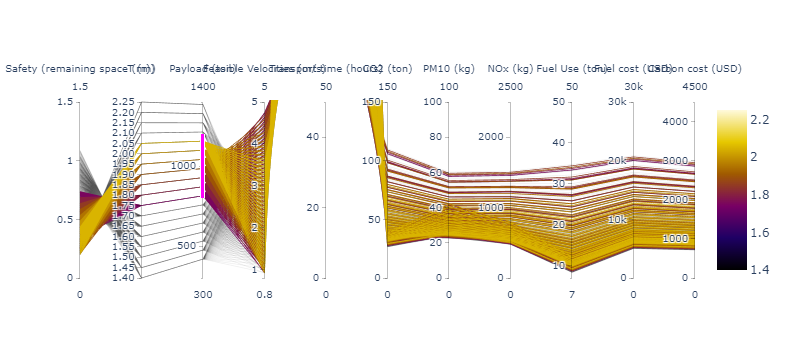

In [34]:

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = strategies_df['T_strategy'],
                   colorscale = 'Electric',
                   # colorscale = 'armyrose',
                   showscale = True,
                   cmin = 2.25,
                   cmax = 1.4),
        dimensions = list([
            dict(range = [0,1.5],
                 visible = True,
                 label = 'Safety (remaining space (m))', values = strategies_df['Safety (remaining space (m))']),
            dict(tickvals = [1.40,1.45,1.50,1.55,1.60,1.65,1.70,1.75,1.80,1.85,1.90,
                            1.95,2.00,2.05,2.10,2.15,2.20,2.25],
                 ticktext = ['1.40','1.45','1.50','1.55','1.60','1.65','1.70','1.75','1.80','1.85','1.90',
                            '1.95','2.00','2.05','2.10','2.15','2.20','2.25'],
                 label = "T (m)", values = strategies_df['T_strategy']),
            dict(range = [300,1400],
                 constraintrange = [800,1200],
                 label = "Payload (ton)", values = strategies_df['Payload_strategy_tanker (ton)']),
            dict(range = [0.8,5],
                 # constraintrange = [2,3.5],
                 label = "Feasible Velocities (m/s)", values = strategies_df['v_feasible']),                       
             dict(range = [0,50],
                 label = 'Transport time (hours)', values = strategies_df['transport time (hours)']),
            dict(range = [0,150],
                 label = 'CO2 (ton)', values = strategies_df['CO2 (ton)']),
            dict(range = [0,100],                
                 label = 'PM10 (kg)', values = strategies_df['PM10 (kg)']),
            dict(range = [0,2500],                 
                 label = 'NOx (kg)', values = strategies_df['NOx (kg)']),
            dict(range = [7,50],
                 # constraintrange = [8,20],
                 label = "Fuel Use (ton)", values = strategies_df['Fuel Use (ton)']),
            dict(range = [0,30000],                 
                 label = 'Fuel cost (USD)', values = strategies_df['Fuel cost (MGO_600USD/ton)']),
            dict(range = [0,4500],
                 # constraintrange = [8,20],
                 label = 'Carbon cost (USD)', values = strategies_df['Carbon cost (EU_27USD/ton)']),            
           
        ]),
    )
)
fig.show()

In [35]:
# If you need to save this file as a standalone html file:
fig.write_html("C:/interactiveCharts/Strategies_and_policies.html")

In [27]:
%%html
<iframe src="C:/interactiveCharts/parallel-coordinate-plot-plotly.html" width="800" height="600" title="parallel coordinate chart with plotly" style="border:none"></iframe>